In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cvxpy as cp
import polytope as pc
import torch
from torch.utils.data import Dataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import polytope
from sklearn.linear_model import LinearRegression

from evanqp import MPCProblem, Polytope, RandomSampler, FFNN, Verifier
from evanqp.layers import BoundArithmetic
from utils import dlqr

In [3]:
class DoubleIntegrator(MPCProblem):
    def __init__(self, N=10):
        self.N = N

        n = 2
        m = 1

        # Double Integrator
        self.A = np.array([[1, 1], [0, 1]])
        self.B = np.array([[0], [1]])
        
        # Weights
        self.Q = np.diag([1, 1])
        self.R = np.array([[0.1]])
        self.K, self.P, _ = dlqr(self.A, self.B, self.Q, self.R)
        
        # Constraints
        self.x_max = np.array([10.0, 10.0])
        self.x_min = np.array([-10.0, -10.0])
        self.u_max = 1.0
        self.u_min = -1.0
        
        # Terminal Set computation
        # state constraints
        Hx = np.vstack((np.eye(n), -np.eye(n)))
        hx = np.concatenate((self.x_max, -self.x_min))
        # input constraints
        Hu = np.vstack((np.eye(m), -np.eye(m)))
        hu = np.array([self.u_max, -self.u_min])
        # closed loop dynamics
        Ak = self.A - self.B @ self.K
        # state & input constraints
        HH = np.vstack((Hx, -Hu @ self.K))
        hh = np.concatenate((hx, hu))
        # compute maximal invariant set
        O = pc.Polytope(HH, hh)
        while True:
            O_prev = O
            # pre-set
            O = O.intersect(pc.Polytope(O.A @ Ak, O.b))
            if O == O_prev:
                break
        self.F, self.f = O.A, O.b

        self.x0 = cp.Parameter(n, name='x0')
        self.x = cp.Variable((N + 1, n), name='x')
        self.u0 = cp.Variable(m, name='u0')
        self.u = cp.Variable((N, m), name='u')
        
        objective = cp.quad_form(self.x[N, :], self.P)
        constraints = [self.x0 == self.x[0, :], self.u0 == self.u[0, :]]
        for i in range(N):
            objective += cp.quad_form(self.x[i, :], self.Q) + cp.quad_form(self.u[i, :], self.R)
            constraints += [self.x[i + 1, :] == self.A @ self.x[i, :] + self.B @ self.u[i, :]]
            constraints += [self.x_min <= self.x[i, :], self.x[i, :] <= self.x_max]
            constraints += [self.u_min <= self.u[i, :], self.u[i, :] <= self.u_max]
        constraints += [self.F @ self.x[N, :] <= self.f]

        self.objective = cp.Minimize(objective)
        self._problem = cp.Problem(self.objective, constraints)

    def problem(self):
        return self._problem

    def parameters(self):
        return [self.x0]

    def variables(self):
        return [self.u0]

    def solve(self, x0):
        self.x0.value = x0
        self._problem.solve(solver=cp.GUROBI, warm_start=True)

        solution = {self.u0: self.u0.value,
                    self.u: self.u.value,
                    self.x: self.x.value,
                    self.objective: self.objective.value}
        return solution
    
    def dynamics(self):
        return (self.A, self.B)

    def reduced_objective(self):
        objective = cp.quad_form(self.x[self.N, :], self.P)
        for i in range(1, self.N):
            objective += cp.quad_form(self.x[i, :], self.Q) + cp.quad_form(self.u[i, :], self.R)
        return cp.Minimize(objective)

In [4]:
mpc_controller = DoubleIntegrator()

In [5]:
x1 = np.linspace(-10, 10, 250)
x2 = np.linspace(-6, 6, 250)
x, y = np.meshgrid(x1, x2)
z_opt = np.zeros(x.shape)
obj_opt = np.zeros(x.shape)
for i in tqdm(range(x.shape[0])):
    for j in range(x.shape[1]):
        sol = mpc_controller.solve(np.array([x[i, j], y[i, j]]))
        u0 = sol[mpc_controller.variables()[0]]
        obj = sol[mpc_controller.objective]
        z_opt[i, j] = u0 if u0 is not None else None
        obj_opt[i, j] = obj if obj is not None else None

  0%|          | 0/250 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2022-12-04


/usr/local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 250/250 [06:27<00:00,  1.55s/it]


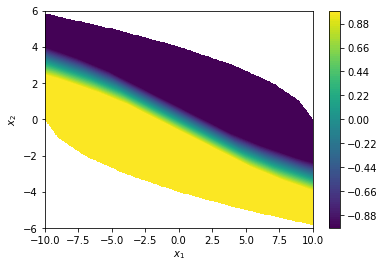

In [6]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, z_opt, levels=100)
fig.colorbar(cs)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

In [7]:
parameter_set = Polytope(np.array([[1, 0], [-1, 0], [0, 1], [0, -1]]), np.array([10, 10, 10, 10]))

In [8]:
sampler = RandomSampler(mpc_controller, parameter_set)
parameter_samples, variable_samples = sampler.sample(10000, seed=0)

100%|██████████| 10000/10000 [02:28<00:00, 67.52it/s]


In [9]:
parameter_samples = torch.from_numpy(parameter_samples).float()
variable_samples  = torch.from_numpy(variable_samples).float()

torch.save(parameter_samples, 'parameter_samples_qp.pt')
torch.save(variable_samples, 'variable_samples_qp.pt')

In [10]:
parameter_samples = torch.load('parameter_samples_qp.pt')
variable_samples  = torch.load('variable_samples_qp.pt')

In [11]:
class DoubleIntegratorDataset(Dataset):
    def __init__(self, parameter_samples, variable_samples):
        self.parameter_samples = parameter_samples
        self.variable_samples = variable_samples

    def __len__(self):
        return self.parameter_samples.shape[0]

    def __getitem__(self, idx):
        return self.parameter_samples[idx, :], self.variable_samples[idx, :]

In [12]:
dataset = DoubleIntegratorDataset(parameter_samples, variable_samples)

seed = 1
train_set_ratio = 0.8

train_set_size = int(len(dataset) * train_set_ratio)
test_set_size = len(dataset) - train_set_size
train_set, test_set = random_split(dataset, [train_set_size, test_set_size], generator=torch.Generator().manual_seed(seed))

In [13]:
!python3 train.py --train-set-ratio {train_set_ratio} --seed {seed} --parameter-samples-file-name parameter_samples_qp.pt --variable-samples-file-name variable_samples_qp.pt --model-file-name double_integrator_ffnn_qp.pt

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.953956
Train Epoch: 1 [1280/8000 (16%)]	Loss: 0.706792
Train Epoch: 1 [2560/8000 (32%)]	Loss: 0.270024
Train Epoch: 1 [3840/8000 (48%)]	Loss: 0.152905
Train Epoch: 1 [5120/8000 (63%)]	Loss: 0.072452
Train Epoch: 1 [6400/8000 (79%)]	Loss: 0.026421
Train Epoch: 1 [7680/8000 (95%)]	Loss: 0.015031

Test set: Average loss: 0.008460)

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.008736
Train Epoch: 2 [1280/8000 (16%)]	Loss: 0.006925
Train Epoch: 2 [2560/8000 (32%)]	Loss: 0.004418
Train Epoch: 2 [3840/8000 (48%)]	Loss: 0.001819
Train Epoch: 2 [5120/8000 (63%)]	Loss: 0.002377
Train Epoch: 2 [6400/8000 (79%)]	Loss: 0.002205
Train Epoch: 2 [7680/8000 (95%)]	Loss: 0.001396

Test set: Average loss: 0.001106)

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.000774
Train Epoch: 3 [1280/8000 (16%)]	Loss: 0.001677
Train Epoch: 3 [2560/8000 (32%)]	Loss: 0.000886
Train Epoch: 3 [3840/8000 (48%)]	Loss: 0.001049
Train Epoch: 3 [5120/8000 (63%)]	Loss: 0.001239
Train Epoch: 3 [6400/8000 (7

In [14]:
saved_model = torch.load('double_integrator_ffnn_qp.pt')

depth = saved_model['depth']
hidden_size = saved_model['hidden_size']

net = FFNN([hidden_size for _ in range(depth)], input_size=saved_model['input_size'], output_size=saved_model['output_size'])
net.load_state_dict(saved_model['state_dict'])

<All keys matched successfully>

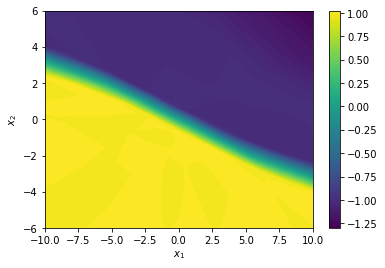

In [15]:
z_net = np.vstack((x.flatten(), y.flatten())).T
z_net = net(torch.from_numpy(z_net).float())
z_net = z_net.detach().cpu().numpy()
z_net = z_net.reshape(x.shape)

fig, ax = plt.subplots()
cs = ax.contourf(x, y, z_net, levels=100)
fig.colorbar(cs)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

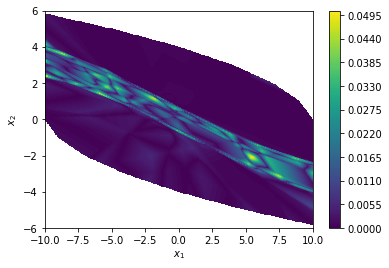

In [16]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=100)
fig.colorbar(cs)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

In [17]:
verifier = Verifier(parameter_set, mpc_controller, net)

In [18]:
mpc_bounds, net_bounds = verifier.compute_bounds(method=BoundArithmetic.INT_ARITHMETIC)
print('Neural Network Bounds:')
print(f'lower bound: {net_bounds["lb"]}')
print(f'upper bound: {net_bounds["ub"]}')

QP Output Bound: 100%|██████████| 1/1 [00:00<00:00, 175.50it/s]

Neural Network Bounds:
lower bound: [-19.54452]
upper bound: [18.35782]


In [19]:
mpc_bounds, net_bounds = verifier.compute_bounds(method=BoundArithmetic.ZONO_ARITHMETIC)
print('Neural Network Bounds:')
print(f'lower bound: {net_bounds["lb"]}')
print(f'upper bound: {net_bounds["ub"]}')

QP Output Bound: 100%|██████████| 1/1 [00:00<00:00, 227.26it/s]

Neural Network Bounds:
lower bound: [-16.74915]
upper bound: [15.27021]


In [20]:
bound_diff, parameters_diff = verifier.approximation_error()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 695 rows, 484 columns and 2699 nonzeros
Model fingerprint: 0xaf39976d
Model has 278 general constraints
Variable types: 345 continuous, 139 integer (139 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-01, 1e+06]
  RHS range        [2e-02, 1e+06]
  GenCon rhs range [6e-01, 1e+01]
  GenCon coe range [4e-01, 1e+00]

User MIP start produced solution with objective 0.00708794 (0.01s)
User MIP start produced solution with objective 0.00753236 (0.01s)
Loaded user MIP start with objective 0.00753236

Presolve removed 212 rows and 174 columns
Presolve time: 0.05s
Presolved: 483 rows, 310 columns, 2593 nonzeros
Presolved model has 36 SOS constraint(s)
Variable types: 199 continuous, 111 integer (111 binary)

Root relaxation: objective 1.219788e+01, 400 iterations, 

In [21]:
print(f'Maximum absolute Error Bound between MPC and NN: {bound_diff} at {parameters_diff}')
u0_mpc = mpc_controller.solve(np.array(parameters_diff))[mpc_controller.u0][0]
u0_net = net(torch.from_numpy(np.array(parameters_diff)).float()).detach().numpy()[0]
print(f'Double Checking by calulcaing error at this position: {u0_mpc - u0_net}')

Maximum absolute Error Bound between MPC and NN: 0.050766191223634766 at [-10.        2.42015]
Double Checking by calulcaing error at this position: 0.05070798146453881


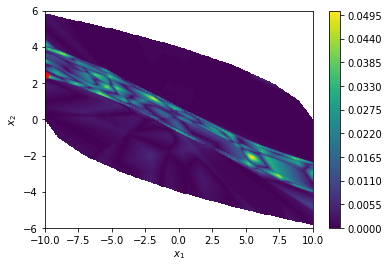

In [22]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=100)
ax.plot(parameters_diff[0], parameters_diff[1], 'ro')
fig.colorbar(cs)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

In [23]:
bound, parameters = verifier.verify_stability_sufficient()

QP Output Bound: 100%|██████████| 1/1 [00:00<00:00, 174.63it/s]


Set parameter NonConvex to value 2
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 814 rows, 547 columns and 2894 nonzeros
Model fingerprint: 0x213879cc
Model has 63 quadratic objective terms
Model has 276 general constraints
Variable types: 408 continuous, 139 integer (139 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+06]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-01, 7e+00]
  Bounds range     [2e-01, 1e+06]
  RHS range        [2e-02, 1e+06]
  GenCon rhs range [6e-01, 1e+01]
  GenCon coe range [4e-01, 1e+00]

User MIP start produced solution with objective 287.583 (0.23s)
User MIP start produced solution with objective 283.784 (0.24s)
User MIP start produced solution with objective 12.1409 (0.64s)
User MIP start produced solution with objective 12.1398 (0.67s)
User MIP start produced solution with objective 12.1398 (0.68s)
Loaded user MIP start 

In [24]:
print(f'Stability bound: {bound} at {parameters}, should be >=0 for stability')

Stability bound: -1.0484585323368478e-06 at [ 0.00011 -0.00024], should be >=0 for stability


In [25]:
bound, parameters = verifier.verify_stability_direct()

QP Output Bound: 100%|██████████| 1/1 [00:00<00:00, 225.74it/s]


Set parameter NonConvex to value 2
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 821 rows, 554 columns and 2912 nonzeros
Model fingerprint: 0x92b6e137
Model has 66 quadratic objective terms
Model has 276 general constraints
Variable types: 415 continuous, 139 integer (139 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+06]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-01, 7e+00]
  Bounds range     [2e-01, 1e+06]
  RHS range        [2e-02, 1e+06]
  GenCon rhs range [6e-01, 1e+01]
  GenCon coe range [4e-01, 1e+00]

User MIP start produced solution with objective 317.176 (0.31s)
User MIP start produced solution with objective 284.003 (0.31s)
User MIP start produced solution with objective 49.0518 (0.34s)
User MIP start produced solution with objective 49.0518 (0.74s)
Loaded user MIP start with objective 49.0518

Presolve removed 283 rows and 197 column

In [26]:
print(f'Stability bound: {bound} at {parameters}, should be >=0 for stability')

Stability bound: -1.1015449843537054e-06 at [-0.00036 -0.00025], should be >=0 for stability


In [27]:
faces = 100
angles = np.linspace(0, 2*np.pi, faces+1)[:faces]
A = np.column_stack((np.cos(angles), np.sin(angles)))
b = np.zeros(faces)
seed_poly = Polytope(A, b)

In [28]:
outer_approx = verifier.stable_region_outer_approx(seed_poly)

100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


In [29]:
print('Outer Approximation of Stable Set: A =')
print(outer_approx.A)
print('b =')
print(outer_approx.b)

Outer Approximation of Stable Set: A =
[[ 1.       0.     ]
 [ 0.99803  0.06279]
 [ 0.99211  0.12533]
 [ 0.98229  0.18738]
 [ 0.96858  0.24869]
 [ 0.95106  0.30902]
 [ 0.92978  0.36812]
 [ 0.90483  0.42578]
 [ 0.87631  0.48175]
 [ 0.84433  0.53583]
 [ 0.80902  0.58779]
 [ 0.77051  0.63742]
 [ 0.72897  0.68455]
 [ 0.68455  0.72897]
 [ 0.63742  0.77051]
 [ 0.58779  0.80902]
 [ 0.53583  0.84433]
 [ 0.48175  0.87631]
 [ 0.42578  0.90483]
 [ 0.36812  0.92978]
 [ 0.30902  0.95106]
 [ 0.24869  0.96858]
 [ 0.18738  0.98229]
 [ 0.12533  0.99211]
 [ 0.06279  0.99803]
 [-0.       1.     ]
 [-0.06279  0.99803]
 [-0.12533  0.99211]
 [-0.18738  0.98229]
 [-0.24869  0.96858]
 [-0.30902  0.95106]
 [-0.36812  0.92978]
 [-0.42578  0.90483]
 [-0.48175  0.87631]
 [-0.53583  0.84433]
 [-0.58779  0.80902]
 [-0.63742  0.77051]
 [-0.68455  0.72897]
 [-0.72897  0.68455]
 [-0.77051  0.63742]
 [-0.80902  0.58779]
 [-0.84433  0.53583]
 [-0.87631  0.48175]
 [-0.90483  0.42578]
 [-0.92978  0.36812]
 [-0.95106  0.30

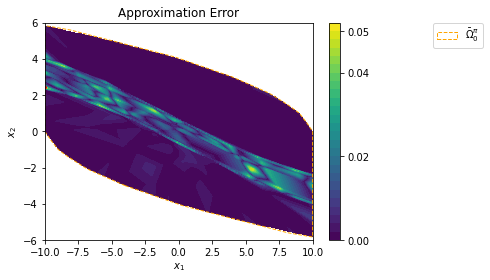

In [30]:
#import latexify
#latexify.latexify(fig_width=3.39/2)

outer_approx_poly = polytope.Polytope(outer_approx.A, outer_approx.b)

fig, ax = plt.subplots()
outer_approx_poly.plot(ax=ax, color=(1,0,0,0), alpha=None, linewidth=1, edgecolor='orange')
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=30, zorder=-1)
for c in cs.collections:
    c.set_edgecolor('face')
    c.set_linewidth(0.000000000001)
ax.plot(parameters_diff[0], parameters_diff[1], 'ro', markersize=2)
ax.set_title('Approximation Error')
fig.colorbar(cs, ticks=[0, 0.02, 0.04, 0.05])
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.legend([r'$\bar{\Omega}_0^\pi$'], bbox_to_anchor=(1.45, 1), loc='upper left', borderaxespad=0.)
plt.savefig('figures/approx_error_outer.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [31]:
verifier = Verifier(parameter_set, mpc_controller)
lip_constant_mpc, gain_mpc, parameters = verifier.lipschitz_constant()

QP Gain Bound: 100%|██████████| 1/1 [00:00<00:00, 32.15it/s]


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1087 rows, 644 columns and 2490 nonzeros
Model fingerprint: 0x880fc970
Model has 387 general constraints
Variable types: 580 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [2e-01, 5e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+06]
  RHS range        [6e-01, 1e+06]
  GenCon rhs range [6e-01, 1e+01]
  GenCon coe range [4e-01, 1e+00]
Presolve removed 576 rows and 275 columns
Presolve time: 0.02s
Presolved: 511 rows, 369 columns, 1438 nonzeros
Presolved model has 181 SOS constraint(s)
Variable types: 261 continuous, 108 integer (108 binary)

Root relaxation: objective 4.573280e+06, 320 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

 

In [32]:
print(f'Lipschitz constant Inf-Norm: {lip_constant_mpc}')
print(f'Gain MPC:')
print(gain_mpc)
print(f'at {parameters}')

Lipschitz constant Inf-Norm: 1.5456270370495675
Gain MPC:
[[-0.57917 -1.54563]]
at [-5.39529  2.66869]


In [33]:
verifier = Verifier(parameter_set, net)
lip_constant_nn, gain_nn, parameters = verifier.lipschitz_constant()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1131 rows, 539 columns and 6304 nonzeros
Model fingerprint: 0x23c9f92d
Model has 151 general constraints
Variable types: 464 continuous, 75 integer (75 binary)
Coefficient statistics:
  Matrix range     [3e-04, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-01, 4e+01]
  RHS range        [2e-03, 4e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 268 rows and 130 columns
Presolve time: 0.05s
Presolved: 863 rows, 409 columns, 5743 nonzeros
Variable types: 331 continuous, 78 integer (78 binary)

Root relaxation: objective 6.279719e+01, 360 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   62.79719    0   62          -   62.79719      -     -    0s
    

In [34]:
print(f'Lipschitz constant Inf-Norm: {lip_constant_nn}')
print(f'Gain NN:')
print(gain_nn)
print(f'at {parameters}')

Lipschitz constant Inf-Norm: 2.4867609729523585
Gain NN:
[[-1.09583 -2.48676]]
at [-1.72918  1.16895]


In [35]:
terminal_set = Polytope(mpc_controller.F, mpc_controller.f)
verifier = Verifier(terminal_set, mpc_controller, net)
lip_constant_error, gain_mpc, gain_nn, parameters = verifier.approximation_error_lipschitz_constant()

QP Gain Bound: 100%|██████████| 1/1 [00:00<00:00, 26.26it/s]


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2214 rows, 1174 columns and 8798 nonzeros
Model fingerprint: 0xb7e9d7d4
Model has 535 general constraints
Variable types: 1035 continuous, 139 integer (139 binary)
Coefficient statistics:
  Matrix range     [3e-04, 5e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [4e-02, 2e+06]
  RHS range        [2e-03, 1e+06]
  GenCon rhs range [6e-01, 1e+01]
  GenCon coe range [4e-01, 1e+00]
Presolve removed 904 rows and 453 columns
Presolve time: 0.11s
Presolved: 1310 rows, 721 columns, 6918 nonzeros
Presolved model has 146 SOS constraint(s)
Variable types: 562 continuous, 159 integer (159 binary)

Root relaxation: objective 9.146629e+06, 559 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Ti

In [36]:
print(f'Lipschitz constant Inf-Norm: {lip_constant_error}')
print(f'Gain MPC:')
print(gain_mpc)
print(f'Gain NN:')
print(gain_nn)
print(f'at {parameters}')

Lipschitz constant Inf-Norm: 2.120809639372862
Gain MPC:
[[-0.57917 -1.54563]]
Gain NN:
[[0.19529 0.57518]]
at [ 2.29944 -1.50862]


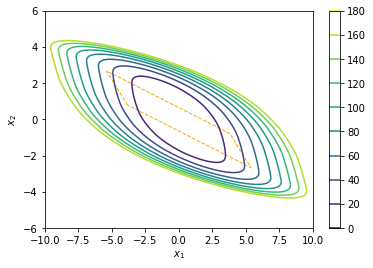

In [37]:
termin_set = polytope.Polytope(mpc_controller.F, mpc_controller.f)
fig, ax = plt.subplots()
termin_set.plot(ax=ax, color=(1,0,0,0), alpha=None, linewidth=1, edgecolor='orange')
obj_opt_clip = np.clip(obj_opt, 0, 180)
cs = ax.contour(x, y, obj_opt_clip, levels=10)
fig.colorbar(cs)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

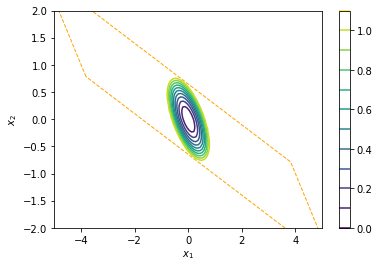

In [38]:
termin_set = polytope.Polytope(mpc_controller.F, mpc_controller.f)
fig, ax = plt.subplots()
termin_set.plot(ax=ax, color=(1,0,0,0), alpha=None, linewidth=1, edgecolor='orange')
obj_opt_clip = np.clip(obj_opt, 0, 1.1)
cs = ax.contour(x, y, obj_opt_clip, levels=10)
fig.colorbar(cs)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
plt.show()

In [39]:
c1 = np.min(np.concatenate((np.linalg.eigvalsh(mpc_controller.Q), np.linalg.eigvalsh(mpc_controller.P))))
print(c1)

1.0


In [40]:
# bound 2 norm by inf norm scaling factor
a = np.sqrt(2)
print(a)

1.4142135623730951


In [41]:
# https://www.sciencedirect.com/science/article/pii/S0005109896002130 (A19)
L = np.ones(mpc_controller.N + 1)
for i in range(1, mpc_controller.N + 1):
    L[i] = (np.linalg.norm(mpc_controller.A, ord=2) + np.linalg.norm(mpc_controller.B, ord=2) * a * lip_constant_mpc) * L[i-1]
K3 = np.sum(L[0:-1])
K4 = mpc_controller.N * a * lip_constant_mpc
K5 = L[-1] * np.max(np.linalg.eigvalsh(mpc_controller.P)) + K3 * np.max(np.linalg.eigvalsh(mpc_controller.Q)) + K4 * np.max(np.linalg.eigvalsh(mpc_controller.R))
c2 = K5
print(c2)

3083435.65716607


In [42]:
def upper_bound_V_satisfied(c2):
    sat = True
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x_0 = np.array([x[i, j], y[i, j]])
            if z_opt[i, j] > c2 * np.linalg.norm(x_0) ** 2:
                sat = False
                break
    return sat

In [43]:
# find c2 numerically using binary search
c2_lower = c1
c2_upper = c2
while c2_upper - c2_lower > 1e-2:
    m = (c2_lower + c2_upper) / 2
    if upper_bound_V_satisfied(m):
        c2_upper = m
    else:
        c2_lower = m
    print(f'{c2_lower} {c2_upper}')

1.0 1541718.328583035
1.0 770859.6642915175
1.0 385430.33214575873
1.0 192715.66607287936
1.0 96358.33303643968
1.0 48179.66651821984
1.0 24090.33325910992
1.0 12045.66662955496
1.0 6023.33331477748
1.0 3012.16665738874
1.0 1506.58332869437
1.0 753.791664347185
1.0 377.3958321735925
1.0 189.19791608679625
1.0 95.09895804339813
1.0 48.049479021699064
24.524739510849532 48.049479021699064
24.524739510849532 36.2871092662743
24.524739510849532 30.405924388561914
27.46533194970572 30.405924388561914
27.46533194970572 28.935628169133818
27.46533194970572 28.200480059419768
27.46533194970572 27.832906004562744
27.46533194970572 27.649118977134233
27.557225463419975 27.649118977134233
27.557225463419975 27.603172220277102
27.58019884184854 27.603172220277102
27.58019884184854 27.591685531062822
27.58019884184854 27.585942186455682


In [44]:
c2 = c2_upper

In [45]:
gamma = (1 - c1/c2)
print(gamma)

0.9637496521510516


In [46]:
s = a * np.linalg.norm(mpc_controller.B, ord=2)
print(s)

1.4142135623730951


In [47]:
c = 180
zeta = (1 - gamma) * c / (s * c2)
print(zeta)

0.16725606071380222


In [48]:
c = 1.1
zeta = (1 - gamma) * c / (s * c2)
print(zeta)

0.0010221203710287913


In [49]:
Acl = mpc_controller.A - mpc_controller.B @ mpc_controller.K

In [50]:
k = np.arange(200)

In [51]:
Aclk_norm = np.zeros(k.shape)
Aclk = np.eye(Acl.shape[0])
for i in range(k.shape[0]):
    Aclk_norm[i] = np.linalg.norm(Aclk)
    Aclk = Acl @ Aclk

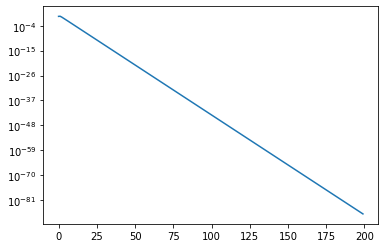

In [52]:
plt.plot(k, Aclk_norm)
plt.yscale('log')
plt.show()

In [53]:
reg = LinearRegression().fit(k[5:].reshape(-1, 1), np.log(Aclk_norm[5:]))

In [54]:
sigma = np.exp(reg.intercept_)
lam = np.exp(reg.coef_[0])
print(sigma)
print(lam)

5.95817402627569
0.3616106229486325


In [55]:
theta = -lam * np.log(lam) / (s * sigma)
print(theta)

0.043652981981620646
